# Introduction

Detecting credit cards fraud with traditional methods is infeasible because of the large amount of data. With Machine Learning we try to build a classifier for this porpuse.

As frauds represent a significantly lower percentage (less than 0.2% in this dataset), we have to consider the following:


1.   We may not only use the accuracy metric, as classifying all transactions to be not fraud will have more than 99.8% of accuracy. 
2.   Eventually, to mislabel a fraud transaction has more impact than mislabeling a real one.
3.   The amount matters, a fraud transaction of amount 100 is more important than a fraud transaction of amount 10. Also, we are asuming that transactions of amount 0 are relevant.

This notebook consists in the test of the tree-based models: [XGBoost](https://xgboost.readthedocs.io/en/latest/install.html), [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [CatBoost](https://catboost.ai/) with both the raw data and Over/Under sampled data, using a method to balance the minority class (the frauds), taken from this [paper](https://arxiv.org/pdf/1106.1813.pdf).

We are using a credit transactions dataset from the Kaggle website: https://www.kaggle.com/mlg-ulb/creditcardfraud

First Import the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_style("darkgrid")
plt.style.use("seaborn")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

Load the dataset.

In [2]:
folder_path = os.getcwd().replace("\\", "/") + "/"
df = pd.read_csv(folder_path + "creditcard.csv")
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

# Data Exploration

The dataset consists in the result of aplying a PCA algorithm to save costumers privacy. There are numeric columns: `Time` which counts the seconds after the first transaction, `V1-V28` masked features, and a categorical column `Class`  that **represents with 0 a real transaction and with 1 a fraud**.

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,54992.0,-0.623235,1.097949,0.748810,0.763394,-0.179458,-0.258895,0.430106,0.466788,-0.935937,...,0.243136,0.468435,-0.055127,-0.012280,-0.236499,-0.327825,0.023302,0.089418,50.00,0
1,145983.0,2.155748,-0.998223,-1.158978,-0.992298,-0.484600,-0.308857,-0.677077,-0.193517,-0.083026,...,0.174775,0.519005,0.003460,-1.017962,-0.009465,-0.118435,-0.006350,-0.053375,58.00,0
2,142073.0,1.614893,-0.194953,-2.050402,1.469645,0.540352,-0.665439,0.677713,-0.246032,-0.079937,...,-0.029061,-0.369654,-0.071308,-0.520915,0.091351,-0.749140,-0.023202,-0.003519,198.00,0
3,132462.0,1.908756,-2.517443,0.277391,-1.466555,-1.521858,3.005920,-2.800770,0.981435,0.349534,...,0.050867,0.984547,0.163995,-0.905736,-0.511626,0.097492,0.147579,-0.036551,82.00,0
4,119001.0,2.120853,-1.048240,-1.895990,-1.236063,-0.038722,-0.274832,-0.388942,-0.196979,-0.649028,...,0.455959,1.125977,-0.263681,-1.322770,0.308495,0.132642,-0.057106,-0.074845,93.75,0


We are dropping the Time column, because the data was taken from the transactions of 2 consecutive days and time may represent a bias in justa short period.

In [4]:
df = df.drop(columns="Time")

Before any analysis, we split the data into Holding and Validation Sets, also **one may not analyze the validation target set to prevent information leakage**. We previously know that **this is an imbalanced data, so we are stratifying the split** (don't rely on RNG). 

In [5]:
df_hold, df_val = train_test_split(df, test_size=0.3, stratify=df["Class"], random_state=456)
df_hold = df_hold.drop_duplicates(keep="first", ignore_index=True)
X_hold = df_hold.drop(columns="Class")
y_hold = df_hold["Class"]
X_val = df_val.drop(columns="Class")
y_val = df_val["Class"]
del df_hold, df_val

The ratio of real vs fraud transactions is

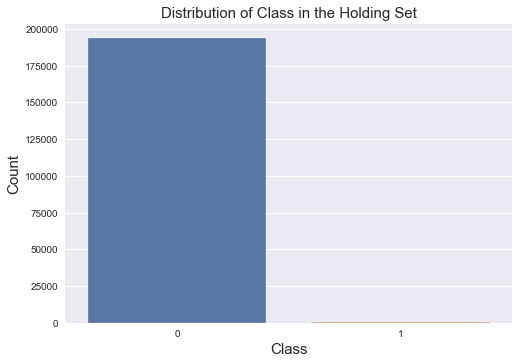

In [6]:
sns.barplot(
    x=y_hold.value_counts().index, y=y_hold.value_counts().values, palette="deep"
)
plt.title("Distribution of Class in the Holding Set", fontsize=15)
plt.xlabel("Class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

In [7]:
original_per = y_hold.value_counts().values[1]/y_hold.value_counts().values[0]
print(f"Only {original_per:.2%} of the Data corresponds to fraud transactions.")

Only 0.17% of the Data corresponds to fraud transactions.


We have the following statistics in the Holding set. It seems that each `V1-V28` column is centered at 0, and almost scaled.

Note: **tree-based models don't require standardized data**.

In [8]:
X_hold.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,...,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000,194162.000000
mean,-0.032616,-0.002615,0.020615,-0.005588,-0.010770,-0.013280,0.004413,-0.005343,-0.010220,0.001990,...,0.001464,0.001869,0.005228,-0.001412,-0.006660,-0.004120,0.001262,0.001285,0.000886,89.936180
std,1.961568,1.670026,1.509665,1.423192,1.361475,1.307900,1.224651,1.203626,1.099980,1.086202,...,0.779797,0.740121,0.726639,0.629351,0.605083,0.523753,0.483794,0.400321,0.333280,246.621263
min,-41.928738,-60.464618,-33.680984,-5.683171,-35.182120,-21.929312,-43.557242,-73.216718,-13.434066,-24.588262,...,-28.009635,-34.830382,-9.499423,-44.807735,-2.824849,-10.295397,-2.604551,-22.565679,-11.710896,0.000000
25%,-0.936366,-0.611994,-0.851608,-0.862239,-0.698520,-0.766193,-0.555834,-0.209517,-0.657380,-0.538061,...,-0.212341,-0.225991,-0.534430,-0.164942,-0.360624,-0.322457,-0.327360,-0.071365,-0.052775,6.080000
50%,-0.046604,0.068937,0.196593,-0.035051,-0.060256,-0.272736,0.041902,0.022267,-0.061804,-0.091227,...,-0.058656,-0.026815,0.011615,-0.013247,0.037032,0.010765,-0.053586,0.002438,0.011641,23.305000
75%,1.297478,0.817819,1.045330,0.745712,0.604374,0.386090,0.581032,0.322940,0.595315,0.468087,...,0.138660,0.189261,0.533658,0.146109,0.433212,0.347582,0.245672,0.094704,0.081097,79.000000
max,2.454930,22.057729,9.382558,16.875344,32.911462,21.550496,36.877368,19.587773,15.594995,23.745136,...,38.117209,27.202839,10.503090,22.528412,4.022866,7.519589,3.463246,10.507884,22.620072,18910.000000


The correlation of each columns is drawn as:

Note: that the dataset is the result of a PCA algorithm, so naturally the columns are not linear correlated.

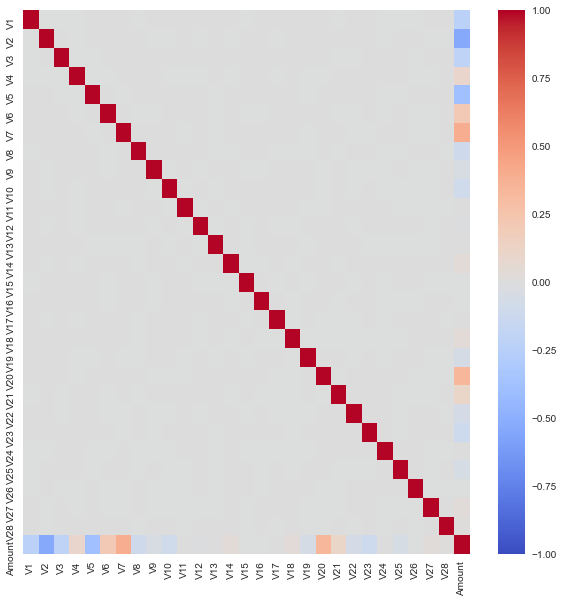

In [9]:
corr = df.drop(columns="Class").corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, center=0, ax=ax)
plt.show()

The distribution of each column and each class is

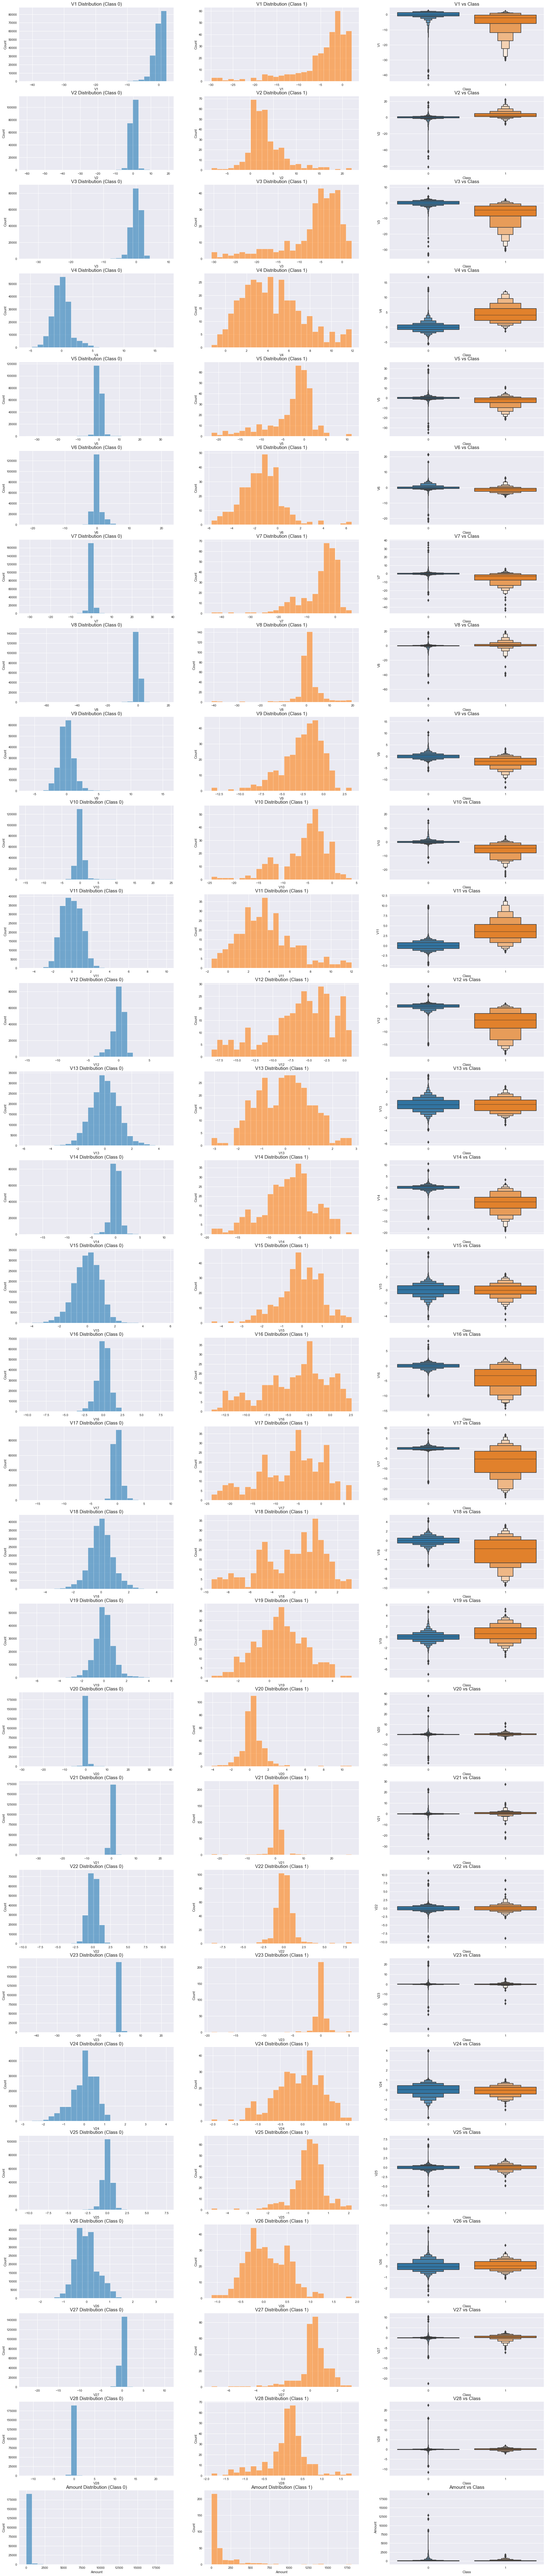

In [10]:
cols = X_hold.columns
len(cols)
palette = sns.color_palette("tab10")
fig, axes = plt.subplots(nrows=len(cols), ncols=3, figsize=(30, 150))
for idx, col in enumerate(cols):
    sns.histplot(X_hold[y_hold == 0][col], bins=25, color=palette[0], ax=axes[idx][0], alpha=0.6)
    axes[idx][0].set_title(label=col + " Distribution (Class 0)", fontsize=15)
    sns.histplot(X_hold[y_hold == 1][col], bins=25, color=palette[1], ax=axes[idx][1], alpha=0.6)
    axes[idx][1].set_title(label=col + " Distribution (Class 1)", fontsize=15)
    sns.boxenplot(x=y_hold, y=X_hold[col], palette=palette, ax=axes[idx][2])
    axes[idx][2].set_title(label=col + " vs Class", fontsize=15)
plt.show()

We have just a few number of fraud transactions so we are not dropping the outliers in the Class 1. And neither in the Class 0 as dropping only for one label may represent a bias in the final model.

## Custom Score

As we have said, predicting all transactions to be real has an accuracy greater than 99.8%, but that's not what this problem is meant to be. We need an score that take into consideration the three points described in the Introduction part.

The Area Under the ROC Curve (AUC), the Precision and the Recall serve to the first and second observations. But for the third one, we must define a new custom score.

The function presented below, considers the amount of each transaction and returns the ratio of money predicted (saved) and the potential money lost if letting all transactions to pass as reals.

The function is fully customizable, but for now, a 2% commission was assumed.

In [11]:
def saved_score(y_pred, amount_column, y_true, percentage_commission=0.02):
    """Function that returns the rate of saved amount from fraud transactions.

    Inputs
    ------
    y_pred : predicted labels,
    amount_column : Amount column,
    y_true : true labels,
    percentage_commission : commission for each transaction as percentage.

    Output
    ------
    1 - sum(loss) / sum(potencial_loss) : Float. The saved Amount percentage, represented as a
                                          number between 0 and 1.
                                          It considers the false positive (the commission) loss and
                                          the false negative (the entire amount minus the
                                          commission) loss.

    """
    if (percentage_commission < 0) or (percentage_commission > 100):
        raise ValueError("percentage_commission must be a number between 0 and 100, inclusive.")
    pred_idx = y_pred != y_true
    pred_rate = abs((y_true[pred_idx]) - percentage_commission)
    pred_loss = sum(pred_rate * amount_column[pred_idx])
    potencial_idx = np.zeros(len(y_true)) != y_true
    potencial_rate = abs((y_true[potencial_idx]) - percentage_commission)
    potencial_loss = sum(potencial_rate * amount_column[potencial_idx])
    if potencial_loss == 0:
        if pred_loss == 0:
            return 1.0
        else:
            return 0.0
    if pred_loss > potencial_loss:
        return 0.0
    return 1 - pred_loss / potencial_loss

To reduce typing, define a function to plot ROC, Precision and Recall Curves.

In [12]:
def plot_curves(y_train, train_proba, y_test, test_proba):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 16))
    # Train Roc Curve Plot
    fp, tp, thresh = roc_curve(y_train, train_proba)
    auc_ = auc(fp, tp)
    axes[0][0].plot(fp, tp, label="AUC = %.3f" % auc_)
    axes[0][0].plot([0,1],[0,1], "r--")
    axes[0][0].set_xlabel("FP rate", fontsize=12)
    axes[0][0].set_ylabel("TP rate", fontsize=12)
    axes[0][0].legend(loc="lower right", fontsize=14)
    axes[0][0].set_title("Train ROC Curve", fontsize=14)
    # Test Roc Curve Plot
    fp, tp, thresh = roc_curve(y_test, test_proba)
    auc_ = auc(fp, tp)
    axes[1][0].plot(fp, tp, label="AUC = %.3f" % auc_)
    axes[1][0].plot([0,1],[0,1], "r--")
    axes[1][0].set_xlabel("FP rate", fontsize=12)
    axes[1][0].set_ylabel("TP rate", fontsize=12)
    axes[1][0].legend(loc="lower right", fontsize=14)
    axes[1][0].set_title("Test ROC Curve", fontsize=14)
    # Train Precision/Recall Plot
    prec, rec, thresh = precision_recall_curve(y_train, train_proba)
    axes[0][1].plot(thresh, prec[1:], label="Precision")
    axes[0][1].plot(thresh, rec[1:], label="Recall")
    axes[0][1].set_xlabel("Threshold", fontsize=12)
    axes[0][1].set_ylabel("Precision/Recall", fontsize=12)
    axes[0][1].legend(fontsize=14)
    axes[0][1].set_title("Train Precision and Recall for different thresholds", fontsize=14)
    # Test Precision/Recall Plot
    prec, rec, thresh = precision_recall_curve(y_test, test_proba)
    axes[1][1].plot(thresh, prec[1:], label="Precision")
    axes[1][1].plot(thresh, rec[1:], label="Recall")
    axes[1][1].set_xlabel("Threshold", fontsize=12)
    axes[1][1].set_ylabel("Precision/Recall", fontsize=12)
    axes[1][1].legend(fontsize=14)
    axes[1][1].set_title("Test Precision and Recall for different thresholds", fontsize=14)
    plt.show()

# Base Classifiers

Import the models libraries.

In [13]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

We present a comparison of some of the well-known tree-based classification algorithms. The parameters selection was done with the help of [optuna package](https://optuna.readthedocs.io/en/stable/), as this is a review, we are omitting the searching code.

## XGBoost Classifier

First, we are fitting a tree based XGBoost classifier.

In [14]:
params = {
    'n_estimators': 150, 
    'max_depth': 5, 
    'learning_rate': 0.10046707166208584, 
    'gamma': 8.0727673537432993, 
    'min_child_weight': 8.202977198221324, 
    'max_delta_step': 8.7488732905466144, 
    'subsample': 0.9269740035861562, 
    'colsample_bytree': 0.1479421071375875, 
    'colsample_bylevel': 0.1508193333658689, 
    'colsample_bynode': 0.1928933234983597, 
    'base_score': 0.5106918903311613, 
    'verbosity': 0, 
    'use_label_encoder': False, 
    'random_state': 741
}
xgbc = XGBClassifier(**params)
xgbc.fit(X_hold, y_hold, eval_metric="auc")

XGBClassifier(base_score=0.5106918903311612, booster='gbtree',
              colsample_bylevel=0.1508193333658689,
              colsample_bynode=0.1928933234983597,
              colsample_bytree=0.1479421071375875, gamma=8.072767353743298,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.10046707166208584,
              max_delta_step=8.748873290546614, max_depth=5,
              min_child_weight=8.202977198221324, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=4,
              num_parallel_tree=1, random_state=741, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9269740035861562,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

The train and test sets' Curves are the following.

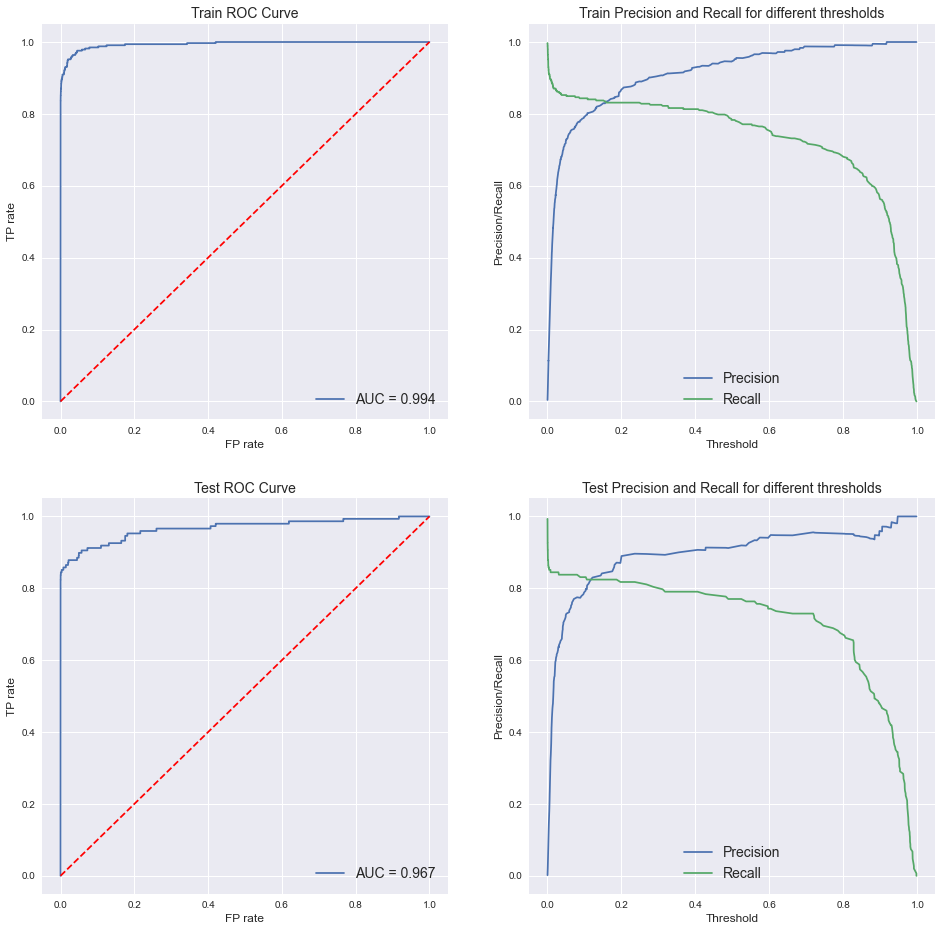

In [15]:
hold_proba = xgbc.predict_proba(X_hold)[:, 1]
val_proba = xgbc.predict_proba(X_val)[:, 1]
plot_curves(y_hold, hold_proba, y_val, val_proba)

Picking out the threshold by eye, we get the following ratio of money saved.

In [16]:
threshold1 = 0.2
threshold2 = 0.2
hold_pred = [1 if proba > threshold1 else 0 for proba in hold_proba]
hold_pred_ = [1 if proba > 0.5 else 0 for proba in hold_proba]
print(f"Training Saved Score for 0.5 threshold: {saved_score(hold_pred_, X_hold.Amount, y_hold):.3f}")
print(f"Training Saved Score for {threshold1} threshold: {saved_score(hold_pred, X_hold.Amount, y_hold):.3f}")
val_pred = [1 if proba > threshold2 else 0 for proba in val_proba]
val_pred_ = [1 if proba > 0.5 else 0 for proba in val_proba]
print(f"Validation Saved Score for 0.5 threshold: {saved_score(val_pred_, X_val.Amount, y_val):.3f}")
print(f"Validation Saved Score for {threshold2} threshold: {saved_score(val_pred, X_val.Amount, y_val):.3f}")

Training Saved Score for 0.5 threshold: 0.675
Training Saved Score for 0.2 threshold: 0.762
Validation Saved Score for 0.5 threshold: 0.685
Validation Saved Score for 0.2 threshold: 0.714


We are doing the same for the next models.

## LGBM Classifier

In [17]:
params = {
    'n_estimators': 150, 
    'num_leaves': 5, 
    'learning_rate': 0.1250862322355519, 
    'subsample_for_bin': 255343, 
    'objective': 'binary', 
    'class_weight': None, 
    'min_split_gain': 0.47701374538210317, 
    'min_child_weight': 0.040994678640748815, 
    'min_child_samples': 255, 
    'subsample': 0.4699277337039556, 
    'colsample_bytree': 0.6806608093930544, 
    'reg_alpha': 0.7256226797632838, 
    'reg_lambda': 0.6072123727187357, 
    'random_state': 741
}
lgbmc = LGBMClassifier(**params)
lgbmc.fit(X_hold, y_hold)

LGBMClassifier(colsample_bytree=0.6806608093930544,
               learning_rate=0.1250862322355519, min_child_samples=255,
               min_child_weight=0.040994678640748815,
               min_split_gain=0.47701374538210317, n_estimators=150,
               num_leaves=5, objective='binary', random_state=741,
               reg_alpha=0.7256226797632838, reg_lambda=0.6072123727187357,
               subsample=0.4699277337039556, subsample_for_bin=255343)

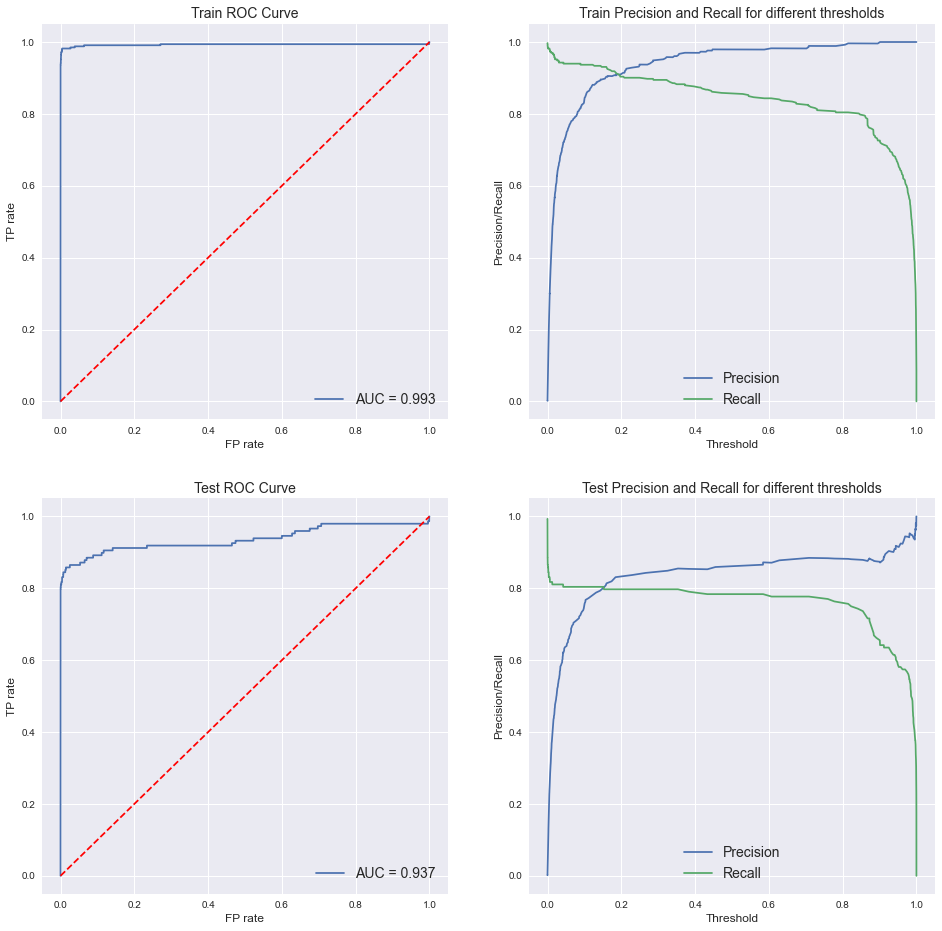

In [18]:
hold_proba = lgbmc.predict_proba(X_hold)[:, 1]
val_proba = lgbmc.predict_proba(X_val)[:, 1]
plot_curves(y_hold, hold_proba, y_val, val_proba)

In [19]:
threshold1 = 0.2
threshold2 = 0.3
hold_pred = [1 if proba > threshold1 else 0 for proba in hold_proba]
hold_pred_ = [1 if proba > 0.5 else 0 for proba in hold_proba]
print(f"Training Saved Score for 0.5 threshold: {saved_score(hold_pred_, X_hold.Amount, y_hold):.3f}")
print(f"Training Saved Score for {threshold1} threshold: {saved_score(hold_pred, X_hold.Amount, y_hold):.3f}")
val_pred = [1 if proba > threshold2 else 0 for proba in val_proba]
val_pred_ = [1 if proba > 0.5 else 0 for proba in val_proba]
print(f"Validation Saved Score for 0.5 threshold: {saved_score(val_pred_, X_val.Amount, y_val):.3f}")
print(f"Validation Saved Score for {threshold2} threshold: {saved_score(val_pred, X_val.Amount, y_val):.3f}")

Training Saved Score for 0.5 threshold: 0.793
Training Saved Score for 0.2 threshold: 0.890
Validation Saved Score for 0.5 threshold: 0.661
Validation Saved Score for 0.3 threshold: 0.670


## CatBoost Classifier

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_hold, y_hold, test_size=0.1, stratify=y_hold, random_state=331)
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [21]:
params =  {
    'iterations': 150, 
    'depth': 5,
    'learning_rate': 0.1171465757247342, 
    'l2_leaf_reg': 8.620922628309947, 
    'random_strength': 0.12663149146003316, 
    'bagging_temperature': 6.895002772372811, 
    'grow_policy': 'Lossguide', 
    'verbose': 0, 
    'random_state': 741
}
catbc = CatBoostClassifier(**params)
catbc.fit(X_train, y_train, eval_set=test_pool, early_stopping_rounds=10)

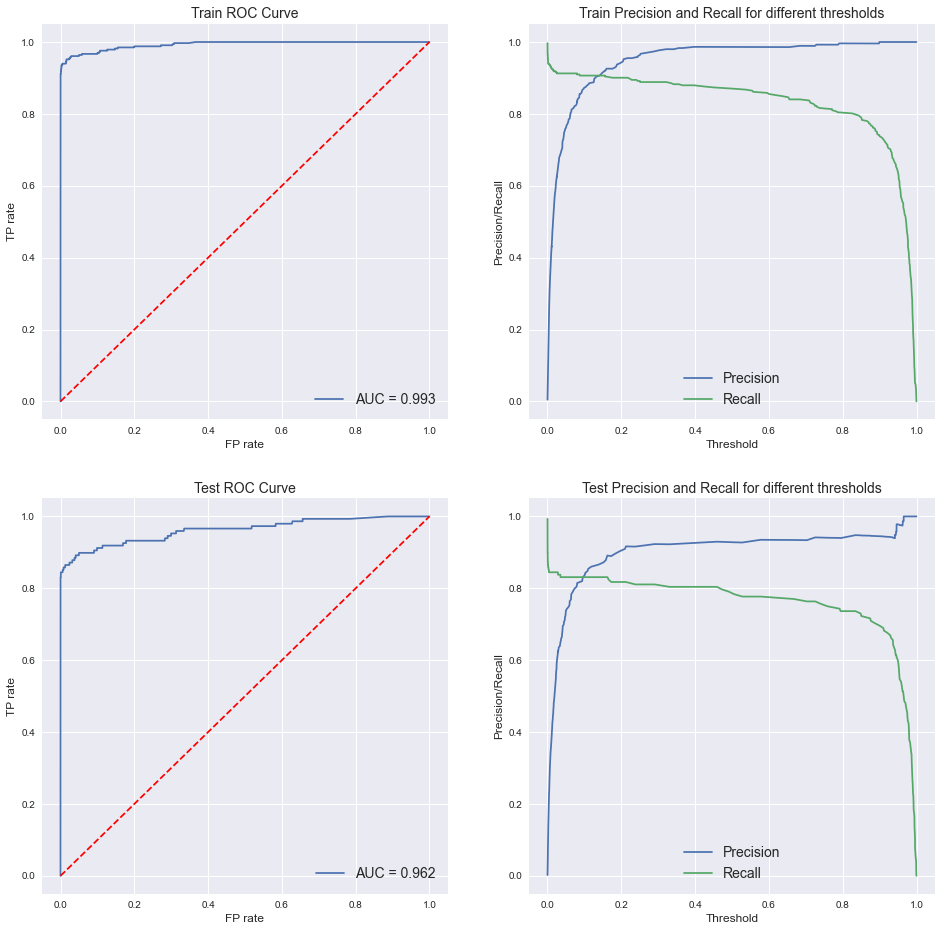

In [22]:
hold_proba = catbc.predict_proba(X_hold)[:, 1]
val_proba = catbc.predict_proba(X_val)[:, 1]
plot_curves(y_hold, hold_proba, y_val, val_proba)

In [23]:
threshold1 = 0.2
threshold2 = 0.2
hold_pred = [1 if proba > threshold1 else 0 for proba in hold_proba]
hold_pred_ = [1 if proba > 0.5 else 0 for proba in hold_proba]
print(f"Training Saved Score for 0.5 threshold: {saved_score(hold_pred_, X_hold.Amount, y_hold):.3f}")
print(f"Training Saved Score for {threshold1} threshold: {saved_score(hold_pred, X_hold.Amount, y_hold):.3f}")
val_pred = [1 if proba > threshold2 else 0 for proba in val_proba]
val_pred_ = [1 if proba > 0.5 else 0 for proba in val_proba]
print(f"Validation Saved Score for 0.5 threshold: {saved_score(val_pred_, X_val.Amount, y_val):.3f}")
print(f"Validation Saved Score for {threshold2} threshold: {saved_score(val_pred, X_val.Amount, y_val):.3f}")

Training Saved Score for 0.5 threshold: 0.821
Training Saved Score for 0.2 threshold: 0.894
Validation Saved Score for 0.5 threshold: 0.670
Validation Saved Score for 0.2 threshold: 0.715


# Smote Method

Only ~0.17% of the total amount of data corresponds to the positive class. **Any model that we fit the data on, will tend to ignore the minority class in order to get better score**, which usually represents a problem.

Two ways to deal with imbalanced data are:
1. Over Sample: Randomly add repeated rows for the positive class in order to increase positive the ratio.
2. Under Sample: Randomly take away negative class rows in order to increase the positive ratio.

Literature have shown that the combination of over and under sampling may work the same as only doing under sampling to the majority class. So we are forced to repeat the minority class with a novel technique.

3. SMOTE: Add new points randomly disturbed with a distance calculated as the difference of the original point and another randomly selected point from it k-nearest neighbors. Colloquially, if there are 2 positives, SMOTE may add a third between them.

Note: There are dozens of SMOTE-variants methods. We are using the classic one.

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Evaluation is made for different ratios up to something more than 5%.

In [25]:
percentages = np.linspace(0, 0.05, 101)
len_per = len(percentages) - 1
rates = [percentage+original_per for percentage in percentages]

## XGBoost Classifier Results

In [26]:
%%time
res_aucs = [0.994]
val_aucs = [0.967]
res_saved = [0.675]
val_saved = [0.685]
for i, percentage in enumerate(percentages[1:]):
    over = SMOTE(sampling_strategy=original_per + percentage/2, random_state=127, k_neighbors=10)
    X_res, y_res = over.fit_resample(X_hold, y_hold)
    under = RandomUnderSampler(sampling_strategy=original_per + percentage, random_state=721)
    X_res, y_res = under.fit_resample(X_res, y_res)
    params = {
        'n_estimators': 150, 
        'max_depth': 5, 
        'learning_rate': 0.10046707166208584, 
        'gamma': 8.0727673537432993, 
        'min_child_weight': 8.202977198221324, 
        'max_delta_step': 8.7488732905466144, 
        'subsample': 0.9269740035861562, 
        'colsample_bytree': 0.1479421071375875, 
        'colsample_bylevel': 0.1508193333658689, 
        'colsample_bynode': 0.1928933234983597, 
        'base_score': 0.5106918903311613, 
        'verbosity': 0, 
        'use_label_encoder': False, 
        'random_state': 741
    }
    xgbc = XGBClassifier(**params)
    xgbc.fit(X_res, y_res, eval_metric="auc")
    res_pred = xgbc.predict(X_res)
    res_aucs.append(roc_auc_score(res_pred, y_res))
    res_saved.append(saved_score(res_pred, X_res["Amount"], y_res))
    val_pred = xgbc.predict(X_val)
    val_aucs.append(roc_auc_score(val_pred, y_val))
    val_saved.append(saved_score(val_pred, X_val["Amount"], y_val))

Wall time: 17min 42s


Text(0.5, 1.0, 'Saved Score vs Added Ratio')

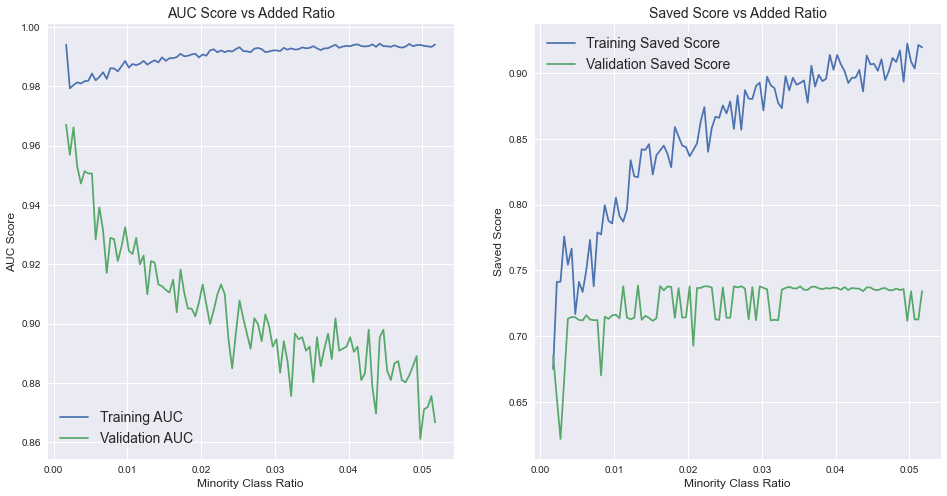

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
# AUC Plot
axes[0].plot(rates, res_aucs, label="Training AUC")
axes[0].plot(rates, val_aucs, label="Validation AUC")
axes[0].set_xlabel("Minority Class Ratio", fontsize=12)
axes[0].set_ylabel("AUC Score", fontsize=12)
axes[0].legend(fontsize=14)
axes[0].set_title("AUC Score vs Added Ratio", fontsize=14)
# Saved Score Plot
axes[1].plot(rates, res_saved, label="Training Saved Score")
axes[1].plot(rates, val_saved, label="Validation Saved Score")
axes[1].set_xlabel("Minority Class Ratio", fontsize=12)
axes[1].set_ylabel("Saved Score", fontsize=12)
axes[1].legend(fontsize=14)
axes[1].set_title("Saved Score vs Added Ratio", fontsize=14)

## LGBM Results

In [28]:
%%time
res_aucs = [0.993]
val_aucs = [0.937]
res_saved = [0.793]
val_saved = [0.661]
for i, percentage in enumerate(percentages[1:]):
    over = SMOTE(sampling_strategy=original_per + percentage/2, random_state=127, k_neighbors=10)
    X_res, y_res = over.fit_resample(X_hold, y_hold)
    under = RandomUnderSampler(sampling_strategy=original_per + percentage, random_state=721)
    X_res, y_res = under.fit_resample(X_res, y_res)
    params = {
        'n_estimators': 150, 
        'num_leaves': 5, 
        'learning_rate': 0.1250862322355519, 
        'subsample_for_bin': 255343, 
        'objective': 'binary', 
        'class_weight': None, 
        'min_split_gain': 0.47701374538210317, 
        'min_child_weight': 0.040994678640748815, 
        'min_child_samples': 255, 
        'subsample': 0.4699277337039556, 
        'colsample_bytree': 0.6806608093930544, 
        'reg_alpha': 0.7256226797632838, 
        'reg_lambda': 0.6072123727187357, 
        'random_state': 741
    }
    lgbmc = LGBMClassifier(**params)
    lgbmc.fit(X_res, y_res)
    res_pred = lgbmc.predict(X_res)
    res_aucs.append(roc_auc_score(res_pred, y_res))
    res_saved.append(saved_score(res_pred, X_res["Amount"], y_res))
    val_pred = lgbmc.predict(X_val)
    val_aucs.append(roc_auc_score(val_pred, y_val))
    val_saved.append(saved_score(val_pred, X_val["Amount"], y_val))

Wall time: 4min 29s


Text(0.5, 1.0, 'Saved Score vs Added Ratio')

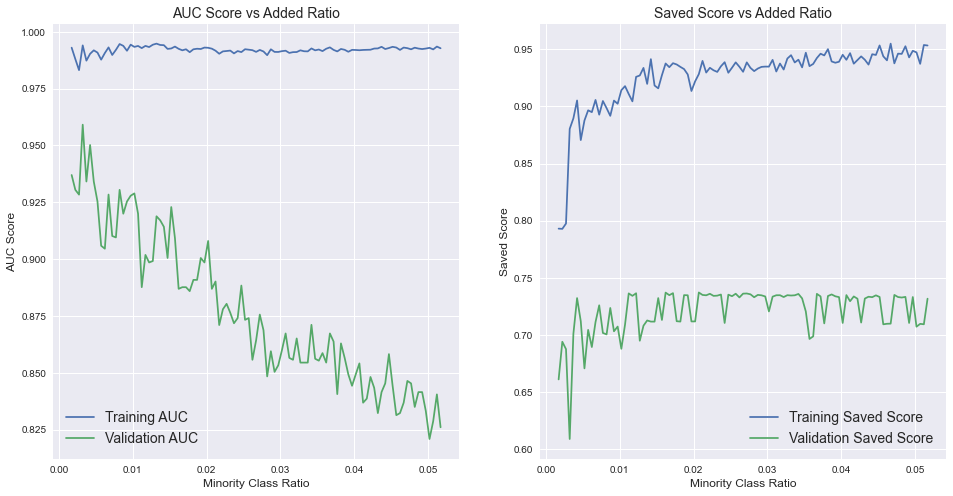

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
# AUC Plot
axes[0].plot(rates, res_aucs, label="Training AUC")
axes[0].plot(rates, val_aucs, label="Validation AUC")
axes[0].set_xlabel("Minority Class Ratio", fontsize=12)
axes[0].set_ylabel("AUC Score", fontsize=12)
axes[0].legend(fontsize=14)
axes[0].set_title("AUC Score vs Added Ratio", fontsize=14)
# Saved Score Plot
axes[1].plot(rates, res_saved, label="Training Saved Score")
axes[1].plot(rates, val_saved, label="Validation Saved Score")
axes[1].set_xlabel("Minority Class Ratio", fontsize=12)
axes[1].set_ylabel("Saved Score", fontsize=12)
axes[1].legend(fontsize=14)
axes[1].set_title("Saved Score vs Added Ratio", fontsize=14)

## CatBoost Classifier Results

In [30]:
%%time
res_aucs = [0.993]
val_aucs = [0.962]
res_saved = [0.821]
val_saved = [0.670]
for i, percentage in enumerate(percentages[1:]):
    over = SMOTE(sampling_strategy=original_per + percentage/2, random_state=127)
    X_res, y_res = over.fit_resample(X_hold, y_hold)
    under = RandomUnderSampler(sampling_strategy=original_per + percentage, random_state=721)
    X_res, y_res = under.fit_resample(X_res, y_res)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1, stratify=y_res, random_state=331)
    train_pool = Pool(X_train, y_train)
    test_pool = Pool(X_test, y_test)
    params =  {
        'iterations': 150, 
        'depth': 5,
        'learning_rate': 0.1171465757247342, 
        'l2_leaf_reg': 8.620922628309947, 
        'random_strength': 0.12663149146003316, 
        'bagging_temperature': 6.895002772372811, 
        'grow_policy': 'Lossguide', 
        'verbose': 0, 
        'random_state': 741
    }
    catbc = CatBoostClassifier(**params)
    catbc.fit(X_train, y_train, eval_set=test_pool, early_stopping_rounds=10)
    res_pred = catbc.predict(X_res)
    res_aucs.append(roc_auc_score(res_pred, y_res))
    res_saved.append(saved_score(res_pred, X_res["Amount"], y_res))
    val_pred = catbc.predict(X_val)
    val_aucs.append(roc_auc_score(val_pred, y_val))
    val_saved.append(saved_score(val_pred, X_val["Amount"], y_val))

Wall time: 17min 7s


Text(0.5, 1.0, 'Saved Score vs Added Ratio')

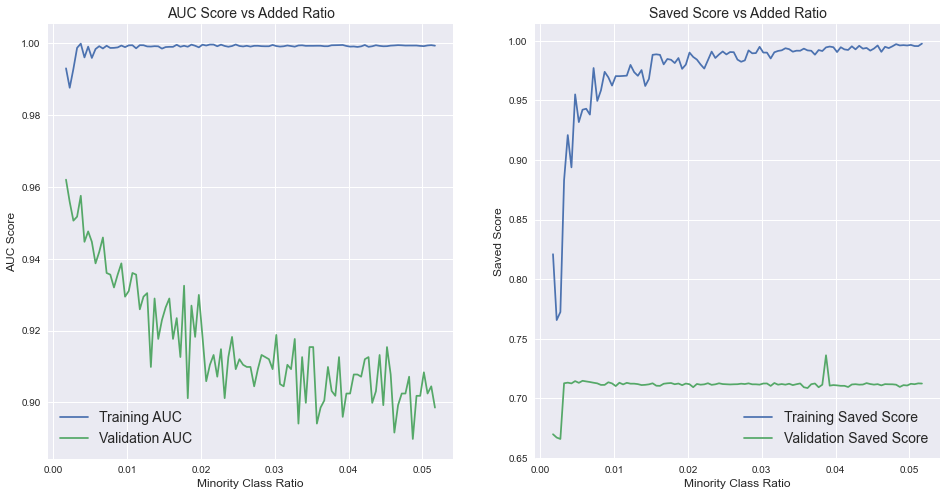

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
# AUC Plot
axes[0].plot(rates, res_aucs, label="Training AUC")
axes[0].plot(rates, val_aucs, label="Validation AUC")
axes[0].set_xlabel("Minority Class Ratio", fontsize=12)
axes[0].set_ylabel("AUC Score", fontsize=12)
axes[0].legend(fontsize=14)
axes[0].set_title("AUC Score vs Added Ratio", fontsize=14)
# Saved Score Plot
axes[1].plot(rates, res_saved, label="Training Saved Score")
axes[1].plot(rates, val_saved, label="Validation Saved Score")
axes[1].set_xlabel("Minority Class Ratio", fontsize=12)
axes[1].set_ylabel("Saved Score", fontsize=12)
axes[1].legend(fontsize=14)
axes[1].set_title("Saved Score vs Added Ratio", fontsize=14)

# Conclusions

The best result was provided by LightGBM Classifier with an smote of something more than 2% corresponding to the minority class. If we redefine the threshold to 0.6, we get the following.

In [32]:
params = {
    'n_estimators': 150, 
    'num_leaves': 5, 
    'learning_rate': 0.1250862322355519, 
    'subsample_for_bin': 255343, 
    'objective': 'binary', 
    'class_weight': None, 
    'min_split_gain': 0.47701374538210317, 
    'min_child_weight': 0.040994678640748815, 
    'min_child_samples': 255, 
    'subsample': 0.4699277337039556, 
    'colsample_bytree': 0.6806608093930544, 
    'reg_alpha': 0.7256226797632838, 
    'reg_lambda': 0.6072123727187357, 
    'random_state': 741
}
over = SMOTE(sampling_strategy=0.011, random_state=127, k_neighbors=10)
X_res, y_res = over.fit_resample(X_hold, y_hold)
under = RandomUnderSampler(sampling_strategy=0.022, random_state=721)
X_res, y_res = under.fit_resample(X_res, y_res)
lgbmc = LGBMClassifier(**params)
lgbmc.fit(X_res, y_res)

LGBMClassifier(colsample_bytree=0.6806608093930544,
               learning_rate=0.1250862322355519, min_child_samples=255,
               min_child_weight=0.040994678640748815,
               min_split_gain=0.47701374538210317, n_estimators=150,
               num_leaves=5, objective='binary', random_state=741,
               reg_alpha=0.7256226797632838, reg_lambda=0.6072123727187357,
               subsample=0.4699277337039556, subsample_for_bin=255343)

In [33]:
hold_proba = lgbmc.predict_proba(X_hold)[:, 1]
val_proba = lgbmc.predict_proba(X_val)[:, 1]
threshold = 0.6
hold_pred = [1 if proba > threshold else 0 for proba in hold_proba]
hold_pred_ = [1 if proba > 0.5 else 0 for proba in hold_proba]
print(f"Training Saved Score for 0.5 threshold: {saved_score(hold_pred_, X_hold.Amount, y_hold):.3f}")
print(f"Training Saved Score for {threshold1} threshold: {saved_score(hold_pred, X_hold.Amount, y_hold):.3f}")
val_pred = [1 if proba > threshold else 0 for proba in val_proba]
val_pred_ = [1 if proba > 0.5 else 0 for proba in val_proba]
print(f"Validation Saved Score for 0.5 threshold: {saved_score(val_pred_, X_val.Amount, y_val):.3f}")
print(f"Validation Saved Score for {threshold2} threshold: {saved_score(val_pred, X_val.Amount, y_val):.3f}")

Training Saved Score for 0.5 threshold: 0.880
Training Saved Score for 0.2 threshold: 0.853
Validation Saved Score for 0.5 threshold: 0.734
Validation Saved Score for 0.2 threshold: 0.735


In [37]:
from sklearn.model_selection import KFold
from sklearn.base import clone

In [40]:
def cross_score(model, k=10):
    
    kf = KFold(n_splits=k, shuffle=True)
    folds = [next(kf.split(X_hold)) for i in range(k)]
    scores = []
    
    for i in range(k):
        over = SMOTE(sampling_strategy=0.011, random_state=127, k_neighbors=10)
        X_res, y_res = over.fit_resample(X_hold.iloc[folds[i][0]], y_hold.iloc[folds[i][0]])
        under = RandomUnderSampler(sampling_strategy=0.022, random_state=721)
        X_res, y_res = under.fit_resample(X_res, y_res)
        
        model_ = clone(model)
        model_.fit(X_res, y_res)
        y_proba = model_.predict_proba(X_hold.iloc[folds[i][1]])[:, 1]
        y_pred = [1 if proba > 0.6 else 0 for proba in y_proba]
    
        score = saved_score(y_pred, X_hold.iloc[folds[i][1]]["Amount"], y_hold.iloc[folds[i][1]])
        scores.append(score)
    
    return np.mean(scores)

In [41]:
lgbmc = LGBMClassifier(**params)
cross = cross_score(lgbmc)
print(f"Cross Validation Saved Score on Training Set: {cross:.3f}")

Cross Validation Saved Score on Training Set: 0.767


We don't have a correlation between Saved Score and AUC Score. This is because, each transaction has a weight associated to it, derived from the Amount to be transacted. 

Passing up an 100-amount fraud transaction has more impact than passing up a 1-amount one, and possibly more impact than blocking multiple real low-amount transactions. So, it's completely possible that a mislabeling greatly reduce the Saved Score, while not affecting the AUC Score at all.

One must choose which condition to stay with, and define a consistent model.

## Things to be done

Some ways to improve the previous construction are the follows:

1. Use other different ML models or an ensemble of them. We decided to use tree-based models, which are known to work well, but a better choice can be made.
2. Use another type of SMOTE. There is a wide range of SMOTE-based algorithms to oversampling, one could be chosen to better suit our problem.
3. Analyze different combinations of Learners, Over/Under-sampling intensities and Recall-Precision thresholds, to find the best of all.